In [1]:
import sys
dir_repo = '../../'
sys.path.append(dir_repo)

from emu_Nx2pt.utils import get_config_from_yaml
from emu_Nx2pt.mlp_emulator import MLP_Emulator

#! rm -rf /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments/mlp_test/

In [2]:
config = get_config_from_yaml(dir_repo+'configs/mlp_test.yaml')
emu = MLP_Emulator(config=config)


------ Parameters ------

exp_name : mlp_test
cuda : True
ngpu : 1
gpu_device : 0
workers : 2
dir_output : /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments
dir_dataT : /home/hhg/Research/emu_Nx2pt/data/train_1M/
filename_pco : /home/hhg/Research/emu_Nx2pt/data/pco_train_1000000.pkl
startID : 0
endID : 10000
f_train : 0.7
seed : 3
Nhidden : 64
Nblocks : 2
num_epochs : 10
batch_size : 64
lr : 0.01
beta1 : 0.5
beta2 : 0.999
step_size : 5
gamma : 0.1
early_stop_threshold : 10
file_cov : /home/hhg/Research/emu_Nx2pt/data/cov3500.pkl
file_mask : /home/hhg/Research/emu_Nx2pt/data/10x2pt_RomanxSO_fid_mask.txt

------ Prepare Data ------

Number of train samples: 7000 (110 batches)
Number of valid samples: 3000 (47 batches)

------ Build Model ------

MLP(
  (in_layer): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
  )
  (mid_layers): ModuleDict(
    (block_0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      

In [3]:
emu.train()


------ Create experiment directory ------

Training information will be stored at :
 	 /home/hhg/Research/emu_Nx2pt/repo/emulator_Nx2pt/experiments/mlp_test
--- Epoch 1/10 ---
	train avg_chi2: 198349.97	valid avg_chi2: 100986.43	Time: 0m 3s
--- Epoch 2/10 ---
	train avg_chi2: 94325.14	valid avg_chi2: 83734.55	Time: 0m 3s
--- Epoch 3/10 ---
	train avg_chi2: 85807.31	valid avg_chi2: 79968.81	Time: 0m 3s
--- Epoch 4/10 ---
	train avg_chi2: 84165.35	valid avg_chi2: 82501.09	Time: 0m 3s
--- Epoch 5/10 ---
	train avg_chi2: 72821.31	valid avg_chi2: 63960.37	Time: 0m 3s
--- Epoch 6/10 ---
	train avg_chi2: 63114.74	valid avg_chi2: 61778.80	Time: 0m 3s
--- Epoch 7/10 ---
	train avg_chi2: 62691.80	valid avg_chi2: 61530.35	Time: 0m 3s
--- Epoch 8/10 ---
	train avg_chi2: 62396.49	valid avg_chi2: 61065.15	Time: 0m 3s
--- Epoch 9/10 ---
	train avg_chi2: 62103.02	valid avg_chi2: 60866.44	Time: 0m 3s
--- Epoch 10/10 ---
	train avg_chi2: 61866.29	valid avg_chi2: 60885.40	Time: 0m 3s

Minimum (epoch-ave

## Plots: Training States

In [3]:
import numpy as np
import torch

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('font', size=16)

In [6]:
trainInfo = torch.load(emu.file_trainInfo)

In [7]:
trainInfo.keys()

dict_keys(['train_loss', 'valid_loss', 'epoch_train_loss', 'epoch_valid_loss', 'lr', 'best_epochID', 'best_model_wts'])

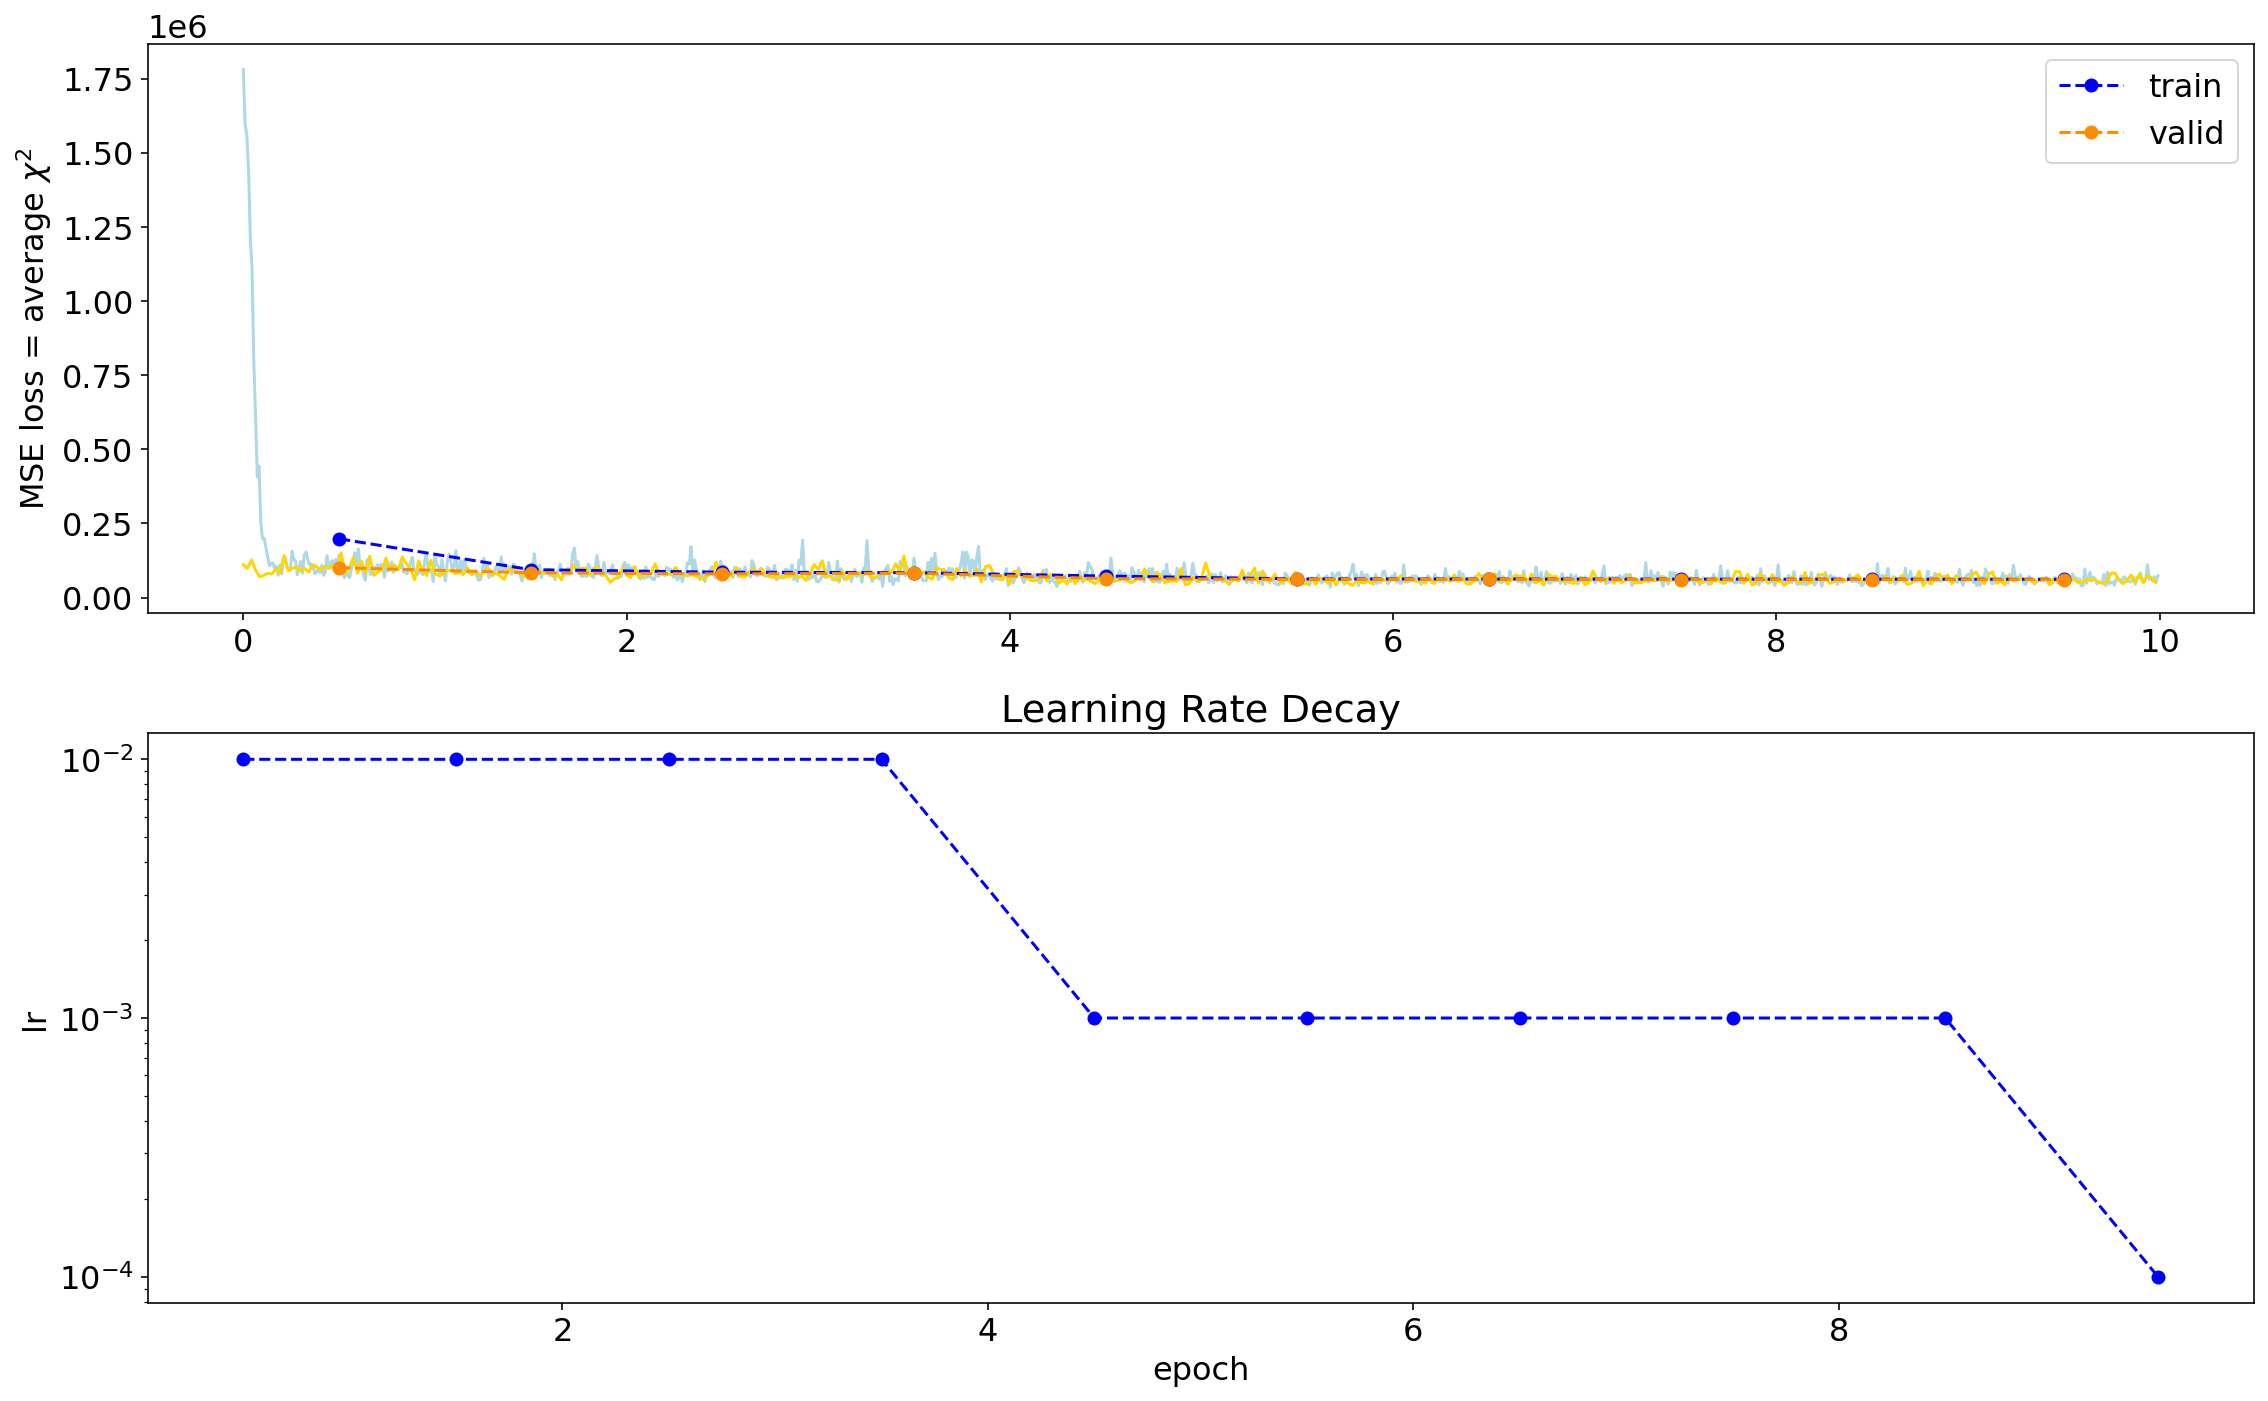

In [8]:
iter_tick = {}
for phase in ['train', 'valid']:
    iter_tick[phase] = np.array(range(len(trainInfo[f'{phase}_loss'])))/len(emu.dataloader[phase])

epoch_tick = np.array(range(len(trainInfo['epoch_train_loss'])))+0.5

# --------------------------

plt.figure(figsize=(16,10))

plt.subplot(211)

n = 1
plt.plot(iter_tick['train'][::n], trainInfo['train_loss'][::n], color='lightblue')
plt.plot(iter_tick['valid'][::n], trainInfo['valid_loss'][::n], color='gold')

plt.plot(epoch_tick, trainInfo['epoch_train_loss'], 'o--', label='train', color='b')
plt.plot(epoch_tick, trainInfo['epoch_valid_loss'], 'o--', label='valid', color='darkorange')

plt.ylabel('MSE loss = average $\chi^2$')

plt.legend()

#plt.xlim([10,20])
#plt.ylim([0,10000])


plt.subplot(212)
plt.plot(epoch_tick, trainInfo['lr'], 'o--', label='train', color='b' )
plt.title('Learning Rate Decay')
plt.ylabel('lr')
plt.yscale('log')
plt.xlabel('epoch')


plt.tight_layout()

## Check the Performance of the Best Trained Emulator

In [4]:
import torch
import pandas as pd
import pickle
from emu_Nx2pt.data_kits import dataTDataset
from torch.utils.data import DataLoader

In [5]:
startID, endID = 900000, 900100  # 1000000
filename_pco = '/home/hhg/Research/emu_Nx2pt/data/pco_train_1000000.pkl'
dir_dataT = '/home/hhg/Research/emu_Nx2pt/data/train_1M/'

with open(filename_pco, 'rb') as handle:
    pco_samples = pickle.load(handle)

test_pco = pd.DataFrame(pco_samples).iloc[startID:endID]

testID = list(range(startID, endID))
test_dataset = dataTDataset(testID, test_pco, dir_dataT)
dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
avg_test_chi2 = emu.test(dataloader)
avg_test_chi2


------ Run test loop ------

  Number of galaxies: 100 (100 batches)
Average chi2 of the test set: 78502.88


78502.87872558594

### Visualize emulated dataV

In [10]:
trainInfo = torch.load(emu.file_trainInfo)
emu.model.load_state_dict(trainInfo['best_model_wts'])

# ---------------------------------------------------------------------------

# stateID = 7
# stateInfo = torch.load(emu.dir_checkpoints + f'/stateInfo_{stateID}.pth')
# emu.model.load_state_dict(stateInfo['model_state_dict'])

<All keys matched successfully>

In [11]:
pcoID, pco, dataT = test_dataset[0]
pco = pco.to(emu.device)

dataV_true = emu.L@dataT.numpy()
dataV_emu  = emu.gen_dataV(pco)

dataT_true = dataT.to('cpu').numpy()
dataT_emu  = emu.gen_dataT(pco)
chi2 = np.sum((dataT_true-dataT_emu)**2)

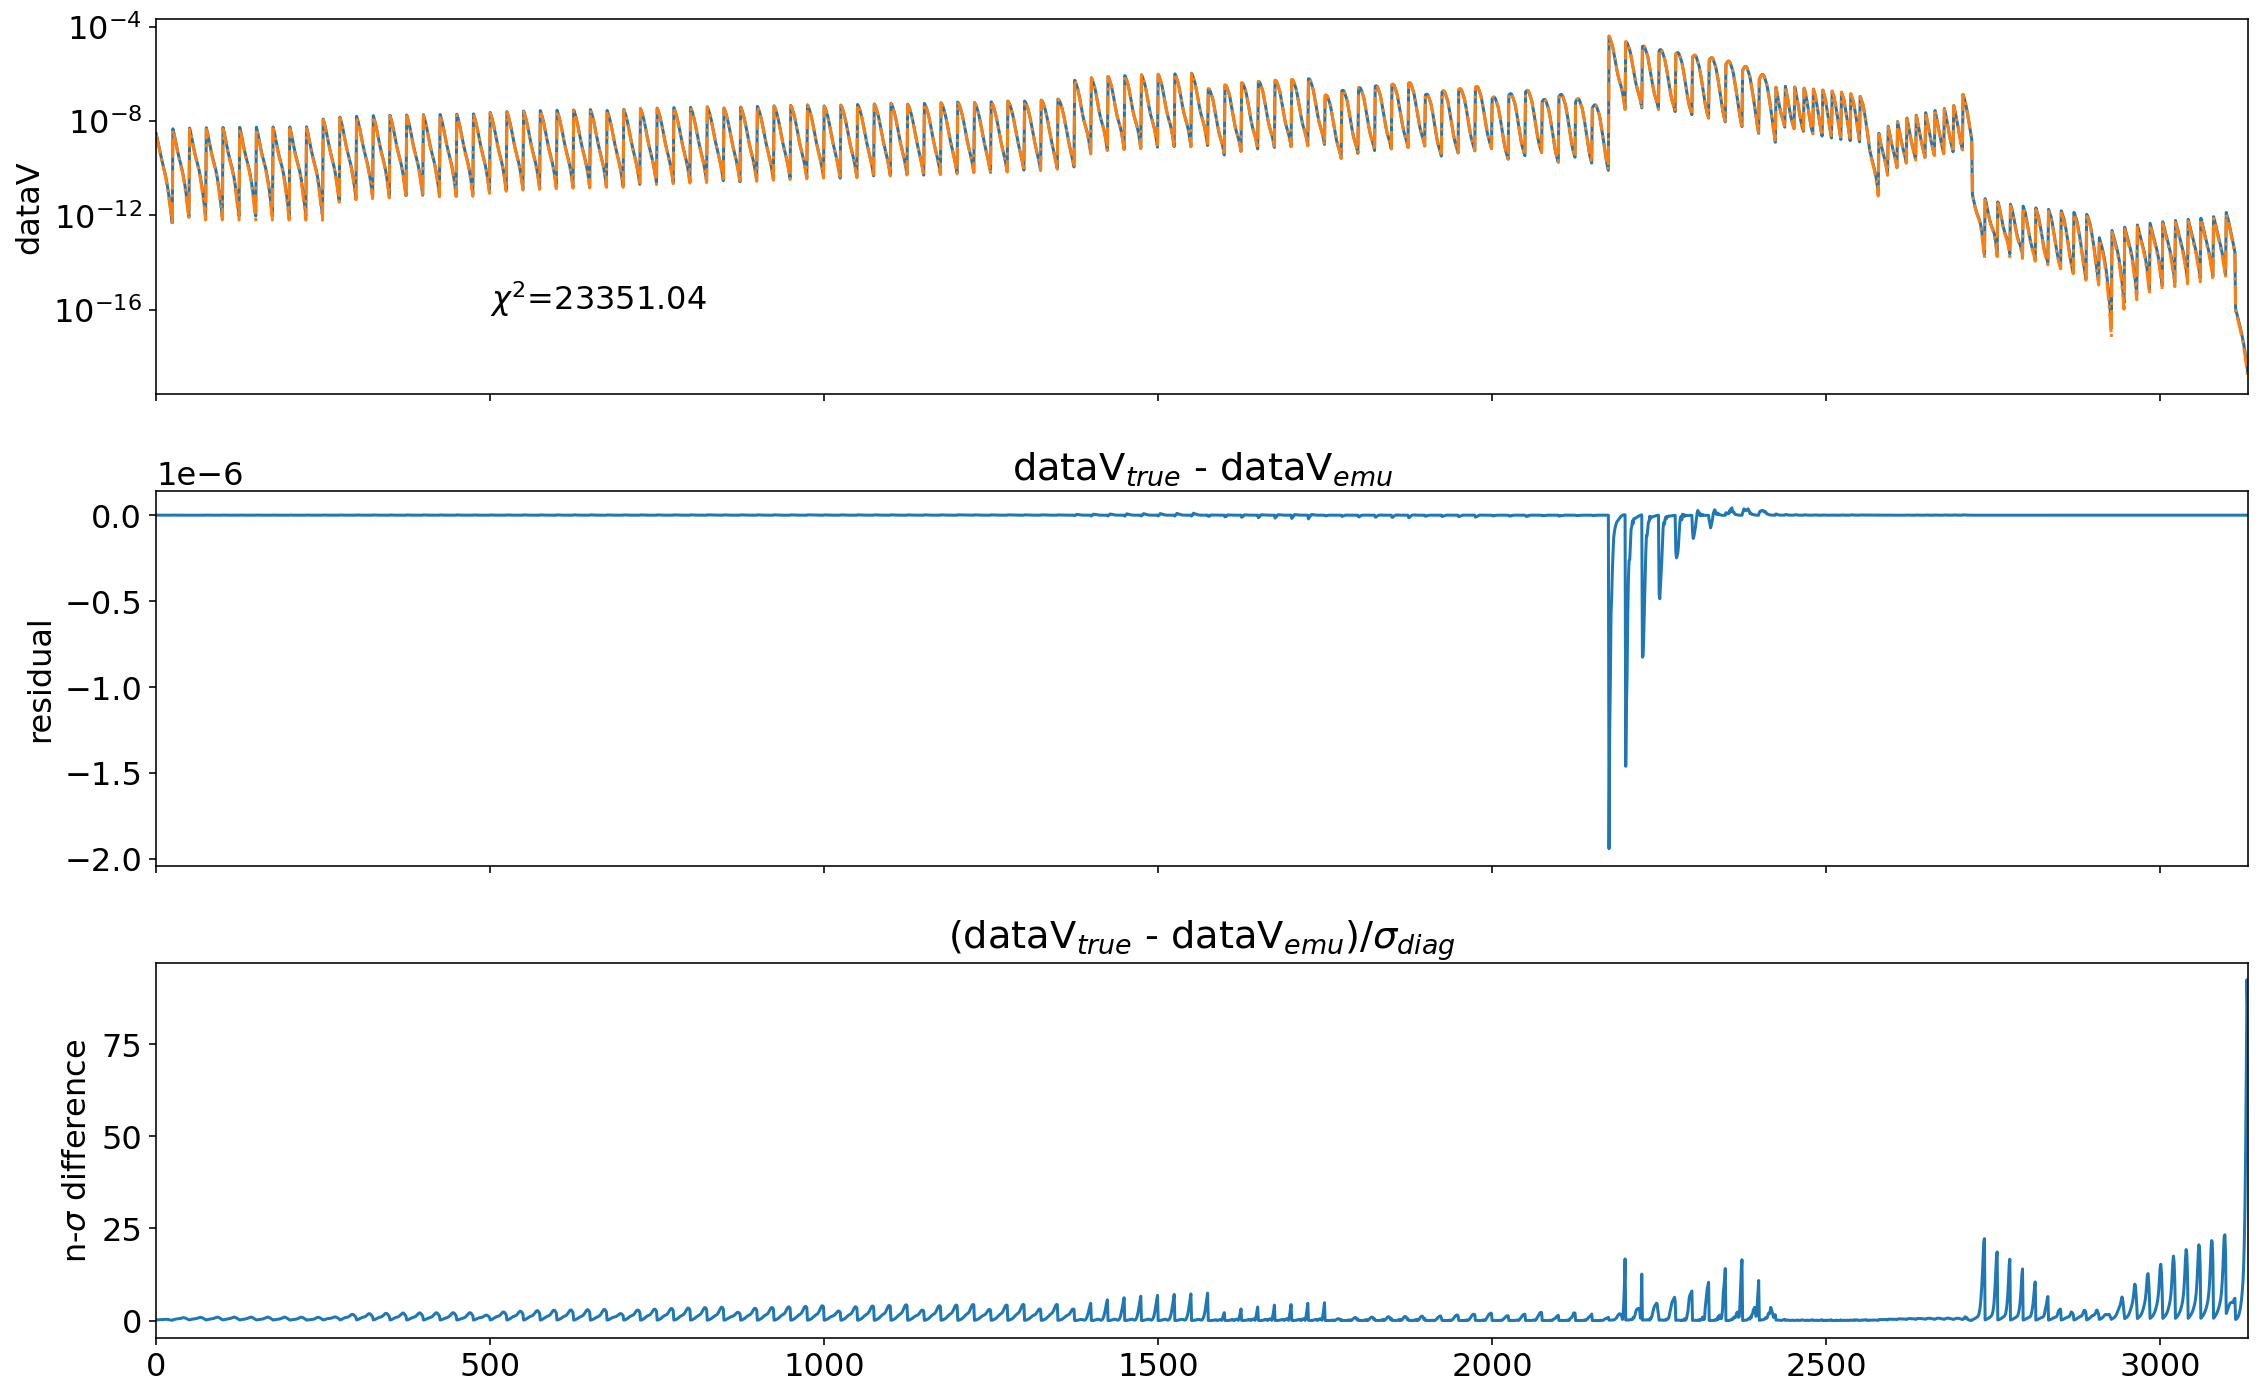

In [20]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.01)

plt.subplot(311)
plt.plot(range(0,emu.Nout), dataV_true)
plt.plot(range(0,emu.Nout), dataV_emu, ls='-.')
plt.text(500, 1e-16, f"$\chi^2$={chi2:.2f}")

plt.yscale('log')
plt.ylabel('dataV')
plt.xlim([0, emu.Nout])
_ = plt.xticks(range(0,emu.Nout, 500),[])

plt.subplot(312)
plt.plot(range(0,emu.Nout), dataV_true-dataV_emu)
plt.ylabel('residual')
plt.title('dataV$_{true}$ - dataV$_{emu}$')
_ = plt.xticks(range(0,emu.Nout, 500),[])
plt.xlim([0, emu.Nout])


plt.subplot(313)
dataV_diag_std = np.sqrt(emu.cov_masked.diagonal())
plt.plot(range(0,emu.Nout), abs(dataV_true-dataV_emu)/dataV_diag_std )
plt.title('(dataV$_{true}$ - dataV$_{emu}$)/$\sigma_{diag}$')
plt.ylabel('n-$\sigma$ difference')
plt.xlim([0, emu.Nout])


plt.tight_layout()